# The whole notebook is an implementation of the paper "arXiv:2101.08176v1". In the paper they used pytorch, here we use tensorflow and keras. But essentially we just repeated what they did. This is meant to be a coding exercise which helps us to get familiar with tensorflow and keras.

# Warning: this notebook will not work on all versions of Keras and TensorFlow. If it doesn't work on your local computer, then you could register a free Kaggle account and run this notebook on Kaggle. 

In [22]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import keras.backend as K
from keras.layers import Input, Lambda, Conv2D, Subtract, Add, Dropout, LeakyReLU, Concatenate
from keras import Model
from matplotlib import pyplot as plt 
import keras
import math

Shape of the features. <br>
**m has to be multiple of batch_size for my custom padding layer to work**

In [23]:
m = 1024 # number of training examples, has to be multiple of batch size for my custom padding layer to work
L = 8 # lattice size
shape = (m,L,L,1)

# 1. Draw samples from I.I.D normal distribution. The output shape is (m,L,L) where m is the number of training examples and L is lattice size.

In [24]:
mu = 0. # mean of all sites of all examples
sigma = 1. # standard deviation of all sites of all examples

X = tf.random.normal(shape, mean = mu, stddev = sigma, dtype = tf.float32)

X = np.array(X)

Convert to pandas dataframe of shape (m, L*L).

In [25]:
X_frame = pd.DataFrame(np.reshape(X,(m, L*L)))

Plot correlation of features to see if they are really independent.

Text(0.5, 1.0, 'Correlation Matrix')

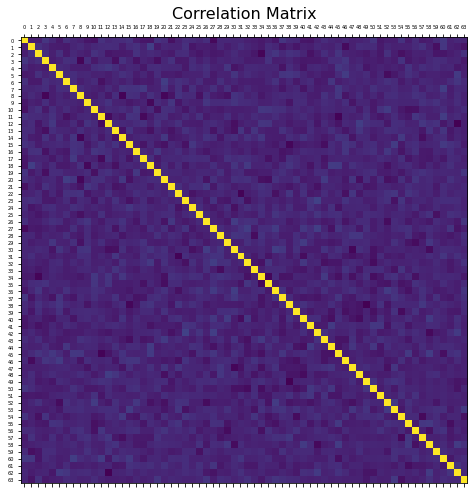

In [26]:
f = plt.figure(figsize=(8, 8))
plt.matshow(X_frame.corr(), fignum=f.number)
plt.xticks(range(X_frame.select_dtypes(['number']).shape[1]), X_frame.select_dtypes(['number']).columns, fontsize=5, rotation=0)
plt.yticks(range(X_frame.select_dtypes(['number']).shape[1]), X_frame.select_dtypes(['number']).columns, fontsize=5)
#cb = plt.colorbar()
#cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

Create a mask with checkboard pattern.

In [27]:
mask = np.zeros((L,L))
for i in range(L):
    for j in range(L):
        if (i + j) % 2 == 0:
            mask[i,j] = 1
            
dual_mask = 1-mask

print(mask)
print('\n',dual_mask)

mask = tf.constant(mask, dtype = tf.float32) # it's important to set dtype as float32 otherwise it's a double tensor
mask = tf.reshape(mask, shape = (1, L, L, 1))                                         # (instead of a float tensor) by default and will lead to error later
    
    
dual_mask = tf.constant(dual_mask, dtype = tf.float32)
dual_mask = tf.reshape(dual_mask, shape = (1, L, L, 1))

[[1. 0. 1. 0. 1. 0. 1. 0.]
 [0. 1. 0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0. 1. 0.]
 [0. 1. 0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0. 1. 0.]
 [0. 1. 0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0. 1. 0.]
 [0. 1. 0. 1. 0. 1. 0. 1.]]

 [[0. 1. 0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0. 1. 0.]
 [0. 1. 0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0. 1. 0.]
 [0. 1. 0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0. 1. 0.]
 [0. 1. 0. 1. 0. 1. 0. 1.]
 [1. 0. 1. 0. 1. 0. 1. 0.]]


# 2. Now we need to define an affine layer. <br>
**phi_1^'=exp(s(phi_2))phi_1+t(phi_2)** <br>
**phi_2^'=phi_2** <br>

According to the paper, the input layer has depth 1, the first hidden layer of the Convolutional Neural Network has 8 filters, the second hidden layers has 8 filters, the output layer has depth 2. We hard-code these things here.

First need to define circular padding function since it's not available in Keras. This will later be wrapped with a Lambda layer.

In [28]:
# the argument x is a tf tensor
def circular_padding(kernel_size): # kernel_size has to be an odd number
    def pad(x):
        # input: x is of shape (mm, siz, siz, filter_num)
        # output: result is of shape (mm, siz+2*thic, siz+2*thic, filter_num)
    
        mm, siz, _, filter_num=x.shape # x has shape (m,hidden_size,hidden_size,filter_number)
        thic=int((kernel_size-1)/2) # kernel_size has to be an odd number
        
        top_left=tf.slice(x,[0, siz-thic, siz-thic, 0], [mm, thic, thic, filter_num])
        top_row=tf.slice(x,[0, siz-thic, 0, 0], [mm, thic, siz, filter_num])
        top_right=tf.slice(x,[0, siz-thic, 0, 0], [mm, thic, thic, filter_num])
        left_column=tf.slice(x,[0, 0, siz-thic, 0], [mm, siz, thic, filter_num])
        right_column=tf.slice(x,[0, 0, 0, 0], [mm, siz, thic, filter_num])
        bottom_left=tf.slice(x,[0, 0, siz-thic, 0], [mm, thic, thic, filter_num])
        bottom_row=tf.slice(x,[0, 0, 0, 0], [mm, thic, siz, filter_num])
        bottom_right=tf.slice(x,[0, 0, 0, 0], [mm, thic, thic, filter_num])
        
        result1=tf.concat([top_left, top_row, top_right], axis=2) 
        result2=tf.concat([left_column, x, right_column], axis=2) 
        result3=tf.concat([bottom_left, bottom_row, bottom_right], axis=2) 
        result=tf.concat([result1, result2, result3], axis=1)
        
        return result
    return pad

Test circular padding.

In [29]:
inp=[[1, 2, 3],[4, 5, 6],[7, 8, 9]]
inp=np.array(inp)
inp=np.reshape(inp,(1, 3, 3, 1))
inp=tf.constant(inp)

res=circular_padding(5)(inp)
print(res.shape)

res=tf.reshape(res, (7, 7))
print(type(res))
print('\n',res)

(1, 7, 7, 1)
<class 'tensorflow.python.framework.ops.EagerTensor'>

 tf.Tensor(
[[5 6 4 5 6 4 5]
 [8 9 7 8 9 7 8]
 [2 3 1 2 3 1 2]
 [5 6 4 5 6 4 5]
 [8 9 7 8 9 7 8]
 [2 3 1 2 3 1 2]
 [5 6 4 5 6 4 5]], shape=(7, 7), dtype=int64)


Define some functions to be later wrapped in Lambda layers.

In [30]:
def slice0(x):
    return tf.slice(x, [0, 0, 0, 0], [x.shape[0], x.shape[1], x.shape[2], 1])

def slice1(x):
    return tf.slice(x, [0, 0, 0, 1], [x.shape[0], x.shape[1], x.shape[2], 1])

def multi(lis): #lis=[a, b]
    a, b = lis
    return a * b

def get_get(minus_mask):
    def get_ln_J(s): # s has shape (mm, L, L, 1)
        ln_J = tf.math.reduce_sum(minus_mask * s, [1,2,3]) # don't sum the 0-th dimension 
        ln_J = tf.reshape(ln_J, (s.shape[0], 1))
        return ln_J # ln_J has shape (mm, 1)
    return get_ln_J

padding_layer = Lambda(circular_padding(3)) # we create these instantiations of layers here because they don't have trainable parameters
leakyrelu_layer = LeakyReLU() # we create these instantiations of layers here because they don't have trainable parameters
multiply_layer = Lambda(multi) # we create these instantiations of layers here because they don't have trainable parameters
slice0_layer = Lambda(slice0)
slice1_layer = Lambda(slice1)
add_layer = Add()

**Now we are ready to define the affine layer.**

In [31]:
class affine_layer(tf.keras.layers.Layer):
    def __init__(self, plus_mask, minus_mask): 
        
        super(affine_layer, self).__init__() 
        
        self.plus_mask = plus_mask
        self.minus_mask = minus_mask
        self.conv2d_a = Conv2D(8, 3, padding='valid', activation = None) # we instantiate these layers here we want new conv2d layers with different weights
        self.conv2d_b = Conv2D(8, 3, padding='valid', activation = None)
        self.conv2d_c = Conv2D(2, 3, padding='valid', activation = 'tanh')
    
    def call(self, input_tensor, training=True):
        
        x_frozen = multiply_layer([self.plus_mask, input_tensor])
        x_active = multiply_layer([self.minus_mask, input_tensor])

        x = padding_layer(x_frozen)
        x = self.conv2d_a(x)
        x = leakyrelu_layer(x)
        
        x = padding_layer(x)
        x = self.conv2d_b(x)
        x = leakyrelu_layer(x)
        
        x = padding_layer(x)
        x = self.conv2d_c(x)
        
        s = slice0_layer(x)
        t = slice1_layer(x)
        
        #output_tensor = (1 - mask) * t + x_active * tf.exp(s) + x_frozen
        output1 = multiply_layer([self.minus_mask, t])
        output2 = multiply_layer([x_active, K.exp(s)]) # inside a layer we need to use backend.exp instead of tf.exp for the back-propagation to work properly
        output_tensor = add_layer([output1, output2])
        output_tensor = add_layer([output_tensor, x_frozen])
        
        ln_J = Lambda(get_get(self.minus_mask))(s)
        
        return output_tensor, ln_J # J here is the determinant of the forward Jacobian matrix  

Test the affine layer.

In [32]:
t1 = time.time()
bbb = affine_layer(dual_mask, mask)
output_tensor, ln_J = bbb(X)
t2 = time.time()
print(t2 - t1)
print(X.shape)
print(output_tensor.shape)
print(ln_J.shape)

0.021620988845825195
(1024, 8, 8, 1)
(1024, 8, 8, 1)
(1024, 1)


Define custom cost function, namely, **KL Divergence**.

In [33]:
# Create a custom loss function as defined in the Phiala papaer
def custom_loss(_, outputs): # y_predict=[ln_q, ln_p]
    ln_q = tf.slice(outputs, [0, 0], [outputs.shape[0], 1])
    ln_p = tf.slice(outputs, [0, 1], [outputs.shape[0], 1]) 
    return K.mean(ln_q - ln_p)  

Calculate the ln(probability) for each configuration, the probability is pior distribution probability. The result X_logp is an array of shape (m,1).<br>
**prob=\Product{exp(-(x-mu)^2/2/sigma^2)/sqrt(2 pi)/sigma}** <br>
**ln(prob)=\Sum{-(x-mu)^2/2/sigma^2}+const** <br>
**-S_physical=ln(prior)-ln_J+const** <br>
, where the Product and Sum is over all L*L components.

Define a function that gets the log of the prior probability.

In [34]:
const = math.log(math.sqrt(2 * math.pi)) + math.log(sigma)

def get_ln_prior(X):
    # input here is just a np array not tf tensor
    ln_prior = - (X - mu) * (X - mu)/2/sigma/sigma - const
    ln_prior = np.sum(ln_prior, axis=(1, 2, 3))
    ln_prior = np.reshape(ln_prior, (X.shape[0], 1))
    return ln_prior

Define the function that calculates the physical action, aka the label Y. **This function is copied from the Phiala paper "Introduction to Normalizing Flows for Lattice Field Theory".** This function will later be wrapped in a Lambda layer.

In [35]:
def ScalarPhi4Action(M2, lam):
    def act(X):
        # potential term, 
        action_density = M2 * X ** 2 + lam * X ** 4
        # kinetic term (discrete Laplacian)
        Nd = len(X.shape) - 2
        dims = range(1, Nd + 1)
        for mu in dims:
            action_density += 2 * X ** 2
            action_density -= X * tf.roll(X, -1, mu)
            action_density -= X * tf.roll(X, 1, mu)
            result = K.sum(action_density, axis = tuple(dims))
        return result
    return act

# 3. Define our model.

In [36]:
batch_size = 1024 # batch_size has to be dividable by total number of training examples
##########################################################
input_X = Input(shape = (L, L, 1,), batch_size = batch_size) # need to specify batch_size, otherwise the shape would be (None, L, L, 1) and custom padding layer won't work
input_ln_prior = Input(shape = (1,), batch_size = batch_size)

propagate = input_X
ln_q = input_ln_prior
##########################################################
for i in range(8):

    propagate, ln_J = affine_layer(mask, dual_mask)(propagate)   
    ln_q = ln_q - ln_J

    propagate, ln_J = affine_layer(dual_mask, mask)(propagate)   
    ln_q = ln_q - ln_J
###########################################################
ln_p = - Lambda(ScalarPhi4Action(-4, 8))(propagate)
outputs = Concatenate(axis = -1)([ln_q, ln_p])
###########################################################
model = Model(inputs = [input_X, input_ln_prior], outputs = outputs)
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.0003), loss = custom_loss) # learning_rate = 0.001 in the original paper

# 4. Train the model.

**According to the original paper:**<br>
**S_physics = S_effective - 8.64** <br>
**-ln_p = -ln_q - 8.64** <br>
**loss = ln_q - ln_p = -8.64** <br>
**Ideally the loss function should be -8.64.**

In [37]:
ver = None
for i in range(50001):
    X = tf.random.normal((batch_size, L, L, 1), mean = mu, stddev = sigma, dtype = tf.float32)
    ln_prior = get_ln_prior(X)
    if i % 1000 == 0:
        ver = 1
        print(i)
    else:
        ver = 0
    # The second argument of fit is X, this is actually a placeholder for Y, since our custom loss function doesn't need a Y.
    model.fit([X, ln_prior], X, batch_size = batch_size, epochs = 1, verbose = ver) # The second argument is fed to the first argument of custom_loss. It's useless for custom_loss.

0
1/1 [==============================] - 15s 15s/step - loss: 12600416256.0000
1000
1/1 [==============================] - 0s 48ms/step - loss: 163771.1562
2000
1/1 [==============================] - 0s 47ms/step - loss: 26257.7051
3000
1/1 [==============================] - 0s 47ms/step - loss: 17571.5176
4000
1/1 [==============================] - 0s 47ms/step - loss: 10894.7607
5000
1/1 [==============================] - 0s 47ms/step - loss: 6727.5117
6000
1/1 [==============================] - 0s 47ms/step - loss: 4746.3652
7000
1/1 [==============================] - 0s 47ms/step - loss: 3094.9395
8000
1/1 [==============================] - 0s 47ms/step - loss: 2337.9470
9000
1/1 [==============================] - 0s 47ms/step - loss: 1848.3813
10000
1/1 [==============================] - 0s 47ms/step - loss: 1285.6216
11000
1/1 [==============================] - 0s 48ms/step - loss: 879.8994
12000
1/1 [==============================] - 0s 47ms/step - loss: 585.0483
13000
1/1 [====

# 5. Evaluate the model.

Define a function that returns the end result configuration. mm=batch_size because we specified batch_size=batch_size when we built the model. <br>
Define a function that returns ln_q. <br>
Define a function that returns ln_p.

In [38]:
inp = model.input                                           # input placeholder
outp = model.layers[-4].output                              # the fourth last layer not the last layer, since the last layer is cancat[ln_q, ln_p]
get_configurations = K.function(inp, outp)                  # evaluation functions

inp = model.input                                           # input placeholder
outp = model.layers[-3].output                              # the third last layer
get_ln_q = K.function(inp, outp)                            # evaluation functions

inp = model.input                                           # input placeholder
outp = model.layers[-2].output                              # the third last layer
get_ln_p = K.function(inp, outp)                            # evaluation functions

X = tf.random.normal((64 * 1024, L, L, 1), mean = mu, stddev = sigma, dtype = tf.float32)
ln_prior = get_ln_prior(X)

ln_q_new = get_ln_q([X, ln_prior])
ln_q_new = np.array(ln_q_new)
ln_q_new = np.reshape(ln_q_new, (ln_q_new.shape[0],))

ln_p_new = get_ln_p([X, ln_prior])
ln_p_new = np.array(ln_p_new)
ln_p_new = np.reshape(ln_p_new, (ln_p_new.shape[0],))

**Ideally the 2d histogram plot should be a straight line with slope = 1 and intercepts with y-axis at -ln(Z), where Z is the partition function. As you can see, our final result is pretty good.** 

1.0179855329985092 -9.427220439842918 (65536,) 



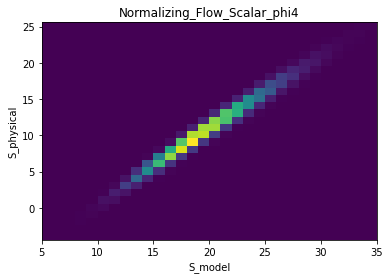

In [39]:
slope, b = np.polyfit(-ln_q_new, -ln_p_new, 1)
print(slope, b, ln_p_new.shape, '\n')
plt.title("Normalizing_Flow_Scalar_phi4") 
plt.xlabel("S_model") 
plt.ylabel("S_physical") 
#plt.figure(figsize = (8, 8))    
xmin = 5
xmax = 35
pl = b 
plt.hist2d(-ln_q_new, -ln_p_new, bins = 30, range=[[xmin, xmax], [xmin + pl, xmax + pl]]) 
#plt.hist2d(-ln_q_new, -ln_p_new, bins = 30) 
plt.show()